River Wang

In [1056]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from collections import Counter
import matplotlib.pyplot as plt

In [1057]:
# import the csv files for each state as dataframes
df_il = pd.read_csv('final_merge_il.csv')
df_ca = pd.read_csv('final_merge_ca.csv')
df_ny = pd.read_csv('final_merge_ny.csv')

# initiate the standard scalelr
scaler = StandardScaler()

/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_36855/2446055564.py:3: DtypeWarning: Columns (10,11,16,17,22,23,28,29,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,100,101,102,103,104,105,106,107,108,109,110,111,118,119,122,123,124,125,128,129,136,137,138,139,142,143,144,145,190,191,192,193,226,362,363,366,367,370,371,374,375,378,379,382,383,386,387,390,391,394,395,398,399,402,403,406,407,410,411,414,415,418,419,420,421,426,427,430,431,434,435,438,439,446,447,450,451,470,471,474,475,478,479,482,483,486,487,490,491,494,495,498,499,502,503,506,507,510,511,514,515,518,519,522,523,526,527,530,531,534,535,538,539,542,543,546,547,550,551,554,555,558,559,562,563,566,567,570,571,574,575,578,579,582,583,590,591,594,595,598,599,602,603,606,607,610,611,618,619,622,623,626,627,630,631,634,635,638,639,642,643,646,647,650,651,654,655,658,659,662,663,666,667,670,671,674,675) 

New York City (Bronx County, Kings County, New York County, Queens County, Richmond County)

In [1058]:
# select relevant features and target values
df_ny = df_ny[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]

# replace '250,000+' and '2,500-' with numerical values and change '-' into missing values
df_ny.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)

# convert the data type into float
df_ny= df_ny.astype(float)

In [1059]:
# create a dictionary that maps feature names to the mean values of each feature
values = {"S1501_C01_014E": df_ny["S1501_C01_014E"].mean(), 
         "S1903_C02_001E": df_ny["S1903_C02_001E"].mean(), 
         "S1903_C02_002E": df_ny["S1903_C02_002E"].mean(), 
         "S1903_C02_003E": df_ny["S1903_C02_003E"].mean(), 
         "DP05_0032PE": df_ny["DP05_0032PE"].mean(), 
         "DP05_0033PE": df_ny["DP05_0033PE"].mean()}

# fill the missing values with mean values
X = df_ny[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE"]]
X.fillna(value=values, inplace=True)

/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_36855/3408277020.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(value=values, inplace=True)


In [1060]:
# standardize the feature matrix
X = scaler.fit_transform(X)

# split the dataset into training and testing data
y = df_ny['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1061]:
# check the balance of the two classes before resampling
print(df_ny['target'].value_counts())

target
0.0    2048
1.0     119
Name: count, dtype: int64


In [1062]:
# undersample the training data according to the minority class
np.random.seed(42) 
class_0_ind = np.where(y_train == 0)[0]
class_1_ind = np.where(y_train == 1)[0]  
num_minority_samples = len(class_1_ind)
undersampled_ind = np.random.choice(class_0_ind, size=num_minority_samples, replace=False)

# combine indices of both classes
undersampled_ind = np.concatenate([undersampled_ind, class_1_ind])

# shuffle indices
np.random.shuffle(undersampled_ind)

# create undersampled training data with equal number of samples from the two classes
X_train_undersam = X_train[undersampled_ind]
y_train_undersam = y_train.iloc[undersampled_ind] 

In [1063]:
# check the number of samples after resampling
print(X_train_undersam.shape)
print(y_train_undersam.shape)

(178, 6)
(178,)


In [1064]:
# initiate a logistic regression model
lr = LogisticRegression(random_state=0)

# set the parameters for grid search
# 'liblinear' works well wtih samll dataset
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.01, 1, 100],
              'solver': ['liblinear']}

# fit the grid search object
# minority class is 1 so use 'recall' to address imbalance in the prediction
grid_cv = GridSearchCV(estimator = lr, param_grid = parameters, scoring='recall', refit='recall', cv=5)
grid_cv.fit(X_train_undersam, y_train_undersam)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 1, 100], 'penalty': ('l1', 'l2'),
                         'solver': ['liblinear']},
             refit='recall', scoring='recall')

In [1065]:
# get the best parameters
grid_cv.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [1066]:
# get the performance score for the best model
grid_cv.best_score_

0.730718954248366

In [1067]:
# test the best model and generate classification report
lr_best = grid_cv.best_estimator_
y_pred = lr_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.50      0.65       404
           1       0.09      0.70      0.17        30

    accuracy                           0.51       434
   macro avg       0.53      0.60      0.41       434
weighted avg       0.90      0.51      0.62       434



As we use 'recall' as the metric for refitting in grid search, the best model has a high score for '1' under 'recall'. In other words, the model does a good job in predicting true positives/actual positives, or real incidents of policde homicide.

In [1068]:
coef = lr_best.coef_.flatten() 
coef_df = pd.DataFrame({'Feature': ["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE"], 'Coefficient': coef})
coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
5,DP05_0033PE,0.094027
3,S1903_C02_003E,-0.060386
4,DP05_0032PE,-0.066061
1,S1903_C02_001E,-0.068366
2,S1903_C02_002E,-0.073847
0,S1501_C01_014E,-0.077564


Among all coefficients, percentage of black population is the most predicative of future police homocides. Percentage of individuals with high school degree or above, and white household median income are also informative to the prediction. It appears that race matters, while income and education also have some correlation to future homicides in New York City.

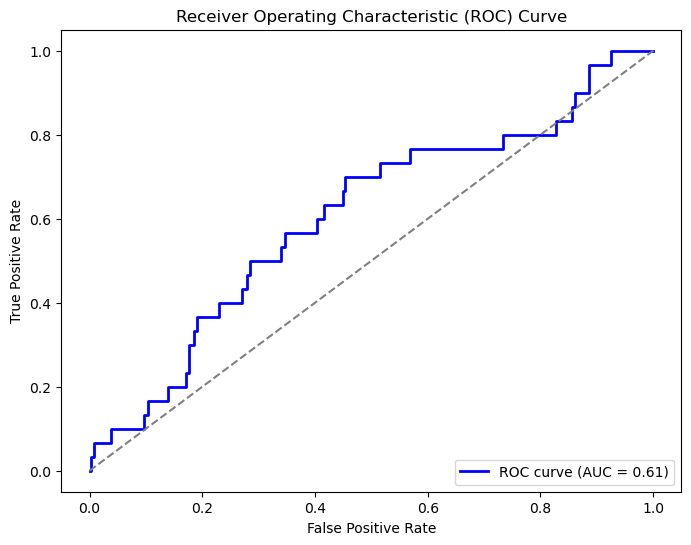

In [1069]:
# compute ROC curve
y_prob = grid_cv.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The model is somewhat useful in separating the two classes or predicting whether there will be police homicides.

Los Angeles (Los Angeles County)

In [1070]:
# select relevant features and target values
df_ca = df_ca[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]

# replace '250,000+' and '2,500-' with numerical values and change '-' into missing values
df_ca.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)

# convert the data type into float
df_ca= df_ca.astype(float)

In [1071]:
# create a dictionary that maps feature names to the mean values of each feature
values = {"S1501_C01_014E": df_ca["S1501_C01_014E"].mean(), 
         "S1903_C02_001E": df_ca["S1903_C02_001E"].mean(), 
         "S1903_C02_002E": df_ca["S1903_C02_002E"].mean(), 
         "S1903_C02_003E": df_ca["S1903_C02_003E"].mean(), 
         "DP05_0032PE": df_ca["DP05_0032PE"].mean(), 
         "DP05_0033PE": df_ca["DP05_0033PE"].mean()}

# fill the missing values with mean values
X = df_ca[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE"]]
X.fillna(value=values, inplace=True)

/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_36855/331809196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(value=values, inplace=True)


In [1072]:
# standardize the feature matrix
X = scaler.fit_transform(X)

# split the dataset into training and testing data
y = df_ca['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1073]:
# check the balance of the two classes before resampling
print(df_ca['target'].value_counts())

target
0.0    1944
1.0     402
Name: count, dtype: int64


In [1074]:
# undersample the training data according to the minority class
np.random.seed(42) 
class_0_ind = np.where(y_train == 0)[0]
class_1_ind = np.where(y_train == 1)[0]  
num_minority_samples = len(class_1_ind)
undersampled_ind = np.random.choice(class_0_ind, size=num_minority_samples, replace=False)

# combine indices of both classes
undersampled_ind = np.concatenate([undersampled_ind, class_1_ind])

# shuffle indices
np.random.shuffle(undersampled_ind)

# create undersampled training data with equal number of samples from the two classes
X_train_undersam = X_train[undersampled_ind]
y_train_undersam = y_train.iloc[undersampled_ind] 

In [1075]:
# check the number of samples after resampling
print(X_train_undersam.shape)
print(y_train_undersam.shape)

(630, 6)
(630,)


In [1076]:
# initiate a logistic regression model
lr = LogisticRegression(random_state=0)

# set the parameters for grid search
# 'liblinear' works well wtih samll dataset
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.01, 1, 100],
              'solver': ['liblinear']}

# fit the grid search object
# minority class is 1 so use 'recall' to address imbalance in the prediction
grid_cv = GridSearchCV(estimator = lr, param_grid = parameters, scoring='recall', refit='recall', cv=5)
grid_cv.fit(X_train_undersam, y_train_undersam)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 1, 100], 'penalty': ('l1', 'l2'),
                         'solver': ['liblinear']},
             refit='recall', scoring='recall')

In [1077]:
# get the best parameters
grid_cv.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [1078]:
# get the performance score for the best model
grid_cv.best_score_

0.5650793650793651

In [1079]:
# test the best model and generate classification report
lr_best = grid_cv.best_estimator_
y_pred = lr_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71       383
           1       0.27      0.66      0.38        87

    accuracy                           0.61       470
   macro avg       0.58      0.63      0.55       470
weighted avg       0.77      0.61      0.65       470



As we use 'recall' as the metric for refitting in grid search, the best model has a high score for '1' under 'recall'. In other words, the model does a good job in predicting true positives/actual positives, or real incidents of policde homicide.

In [1080]:
coef = lr_best.coef_.flatten() 
coef_df = pd.DataFrame({'Feature': ["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE"], 'Coefficient': coef})
coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
5,DP05_0033PE,0.154816
3,S1903_C02_003E,-0.010541
2,S1903_C02_002E,-0.012233
4,DP05_0032PE,-0.017897
1,S1903_C02_001E,-0.069381
0,S1501_C01_014E,-0.144997


Among all coefficients, percentage of black population is the most predicative of future police homocides, while percentage of individuals with high school degree or above is a close second. Percentage of white population has some predicative value. Similar to New York City, it appears that race is rather informative of future homicides in Los Angeles. Education also have some correlation to future homicides.

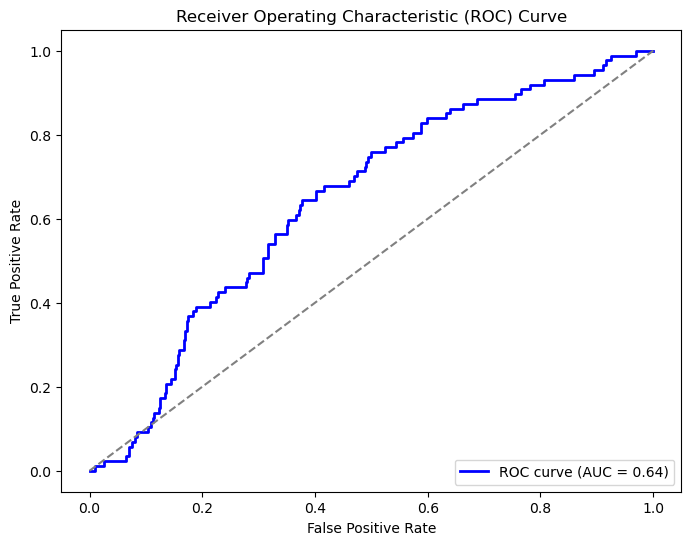

In [1081]:
# compute ROC curve
y_prob = grid_cv.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Compared to the model from New York City, the logistic regression for Los Angeles is slightly more effective in separating the two classes or predicting whether there will be police homicides.

Chicago (Cook County)

In [1082]:
# select relevant features and target values
df_il = df_il[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]

# replace '250,000+' and '2,500-' with numerical values and change '-' into missing values
df_il.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)

# convert the data type into float
df_il = df_il.astype(float)

In [1083]:
# create a dictionary that maps feature names to the mean values of each feature
values = {"S1501_C01_014E": df_il["S1501_C01_014E"].mean(), 
         "S1903_C02_001E": df_il["S1903_C02_001E"].mean(), 
         "S1903_C02_002E": df_il["S1903_C02_002E"].mean(), 
         "S1903_C02_003E": df_il["S1903_C02_003E"].mean(), 
         "DP05_0032PE": df_il["DP05_0032PE"].mean(), 
         "DP05_0033PE": df_il["DP05_0033PE"].mean()}

# fill the missing values with mean values
X = df_il[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE"]]
X.fillna(value=values, inplace=True)

/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_36855/2508843100.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(value=values, inplace=True)


In [1084]:
# standardize the feature matrix
X = scaler.fit_transform(X)

# split the dataset into training and testing data
y = df_il['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1085]:
# check the balance of the two classes before resampling
print(df_il['target'].value_counts())

target
0.0    1185
1.0     134
Name: count, dtype: int64


In [1086]:
# undersample the training data according to the minority class
np.random.seed(42) 
class_0_ind = np.where(y_train == 0)[0]
class_1_ind = np.where(y_train == 1)[0]  
num_minority_samples = len(class_1_ind)
undersampled_ind = np.random.choice(class_0_ind, size=num_minority_samples, replace=False)

# combine indices of both classes
undersampled_ind = np.concatenate([undersampled_ind, class_1_ind])

# shuffle indices
np.random.shuffle(undersampled_ind)

# create undersampled training data with equal number of samples from the two classes
X_train_undersam = X_train[undersampled_ind]
y_train_undersam = y_train.iloc[undersampled_ind] 

In [1087]:
# check the number of samples after resampling
print(X_train_undersam.shape)
print(y_train_undersam.shape)

(206, 6)
(206,)


In [1088]:
# initiate a logistic regression model
lr = LogisticRegression(random_state=0)

# set the parameters for grid search
# 'liblinear' works well wtih samll dataset
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.01, 1, 100],
              'solver': ['liblinear']}

# fit the grid search object
# minority class is 1 so use 'recall' to address imbalance in the prediction
grid_cv = GridSearchCV(estimator = lr, param_grid = parameters, scoring='recall', refit='recall', cv=5)
grid_cv.fit(X_train_undersam, y_train_undersam)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 1, 100], 'penalty': ('l1', 'l2'),
                         'solver': ['liblinear']},
             refit='recall', scoring='recall')

In [1089]:
# get the best parameters
grid_cv.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [1090]:
# get the performance score for the best model
grid_cv.best_score_

0.6414285714285713

In [1091]:
# test the best model and generate classification report
lr_best = grid_cv.best_estimator_
y_pred = lr_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80       233
           1       0.23      0.71      0.35        31

    accuracy                           0.69       264
   macro avg       0.59      0.70      0.58       264
weighted avg       0.86      0.69      0.75       264



As we use 'recall' as the metric for refitting in grid search, the best model has a high score for '1' under 'recall'. In other words, the model does a good job in predicting true positives/actual positives, or real incidents of policde homicide.

In [1092]:
coef = lr_best.coef_.flatten() 
coef_df = pd.DataFrame({'Feature': ["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE"], 'Coefficient': coef})
coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
5,DP05_0033PE,0.166254
3,S1903_C02_003E,-0.003132
0,S1501_C01_014E,-0.013572
2,S1903_C02_002E,-0.026305
1,S1903_C02_001E,-0.119372
4,DP05_0032PE,-0.161550


Again, percentage of black population is the most predicative of future police homocides, while percentage of white population is a close second. Across all three cities, race is constantly informative in terms of prediction of homicides. Household median income also has some correlation to future homicides in Chicago.

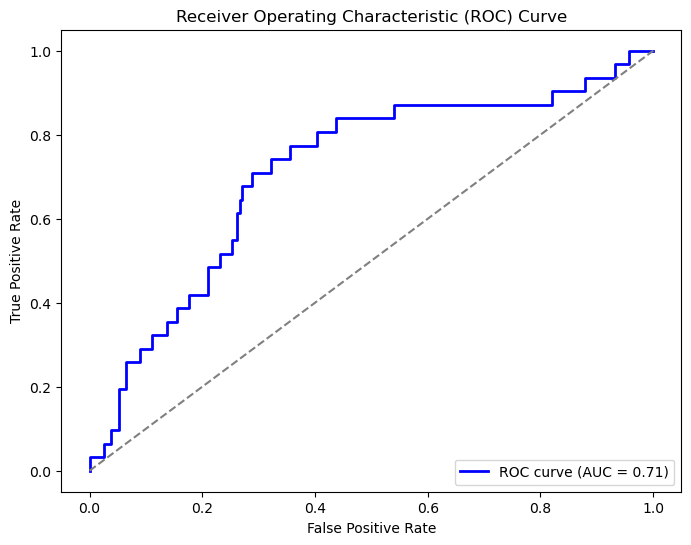

In [1093]:
# compute ROC curve
y_prob = grid_cv.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Compared to the model from Los Anegeles, the logistic regression for Chicago seems to be slightly more effective in separating the two classes or predicting whether there will be police homicides.